In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [6]:
thetas = np.linspace(0, np.pi/2, 20, endpoint=False)
print(thetas)

[0.         0.07853982 0.15707963 0.23561945 0.31415927 0.39269908
 0.4712389  0.54977871 0.62831853 0.70685835 0.78539816 0.86393798
 0.9424778  1.02101761 1.09955743 1.17809725 1.25663706 1.33517688
 1.41371669 1.49225651]


In [55]:
circuits = []
schedules = []

In [56]:
## Standard Way: Cnot RZ Cnot
for theta in thetas:
    circuit = q.QuantumCircuit(2)
    circuit.h(0)
    circuit.h(1)
    circuit.cx(0, 1)
    circuit.rz(theta, 1)
    circuit.cx(0, 1)
    circuit.h(0)
    circuit.h(1)

    decomposed_circuit = circuit.decompose()

    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
    schedule |= measure << schedule.duration
    schedules.append(schedule)
    
    circuits.append(circuit)

In [ ]:
circuit.draw(output='latex')

In [ ]:
schedules[1].draw(channels=[config.drive(0), config.drive(1), config.control(0)])

In [ ]:
## Optimized Way Way: zz_interaction decomposes directly to cross resonancefor theta in thetas:
for theta in thetas:
    circuit = q.QuantumCircuit(2)
    circuit.h(0)
    circuit.h(1)
    circuit.zz_interaction(theta, 0, 1)
    circuit.h(0)
    circuit.h(1)

    decomposed_circuit = circuit.decompose()

    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
    schedule |= measure << schedule.duration
    schedules.append(schedule)

In [ ]:
circuit.draw(output='latex')

In [ ]:
circuit.decompose().draw(output='latex')

In [ ]:
schedules[21].draw(channels=[config.drive(0), config.drive(1), config.control(0)])

In [ ]:
shots = 1000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

In [ ]:
job.status()

# Run a mitigation cal job

In [21]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1])
meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)
job_mit = q.execute(meas_schedules, backend)

/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [32]:
job_mit.status()

<JobStatus.DONE: 'job has successfully run'>

-----
## Analysis

In [40]:
from qiskit.result import marginal_counts

In [33]:
result = backend.retrieve_job('5dd76fabf5613200186ad136').result()

In [43]:
# mitigate results
result_mit = marginal_counts(job_mit.result(), [0,1])
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

array([[0.953125  , 0.0703125 , 0.10253906, 0.01367188],
       [0.03320312, 0.91796875, 0.00292969, 0.08105469],
       [0.01171875, 0.00488281, 0.87695312, 0.08789062],
       [0.00195312, 0.00683594, 0.01757812, 0.81738281]])

In [83]:
standard_counts_list = []
for i in range(len(thetas)):
    counts = marginal_counts(result.get_counts(i), [0,1])
    counts = readout_fitter.filter.apply(counts)
    standard_counts_list.append(counts)
print(standard_counts_list)

[{'00': 988.4673975257247, '01': 3.235132473758319, '10': 5.920102522444265, '11': 2.377367478072932}, {'00': 985.0645828306693, '01': 3.246630744193395, '10': 8.1274594671792, '11': 3.561326957958117}, {'00': 989.4537976786238, '01': 4.568215380055977, '10': 2.0280803945949e-13, '11': 5.977986941320059}, {'00': 988.8824639854263, '10': 1.8372584554932567, '11': 9.280277559080512}, {'00': 971.2645552342282, '10': 1.0613732115416497e-13, '11': 28.735444765772083}, {'00': 945.2529915044737, '01': 2.7599139218303788, '10': 1.6984326514359764, '11': 50.28866192226006}, {'00': 916.2213206423792, '01': 7.960660783010628, '11': 75.81801857461015}, {'00': 911.6974178388807, '01': 8.235173352267358, '10': 4.104291700673454, '11': 75.96311710817847}, {'00': 894.3875546843608, '01': 0.7939536101923281, '10': 11.789788937441873, '11': 93.028702768005}, {'00': 855.1690373338782, '01': 18.686264878043502, '10': 9.88553643247487, '11': 116.2591613556034}, {'00': 853.5286301894357, '01': 3.61808634574

In [84]:
optimized_counts_list = []
for i in range(len(thetas), len(thetas) * 2):
    counts = marginal_counts(result.get_counts(i), [0,1])
    counts = readout_fitter.filter.apply(counts)
    optimized_counts_list.append(counts)
print(optimized_counts_list)

[{'00': 999.9999999963358, '01': 9.049708205033369e-10, '10': 7.588693007321012e-10, '11': 2.0004400913542497e-09}, {'00': 1000.0}, {'00': 968.2272840117462, '01': 7.796247871462746, '10': 3.1788448987206683, '11': 20.797623218070356}, {'00': 964.3330093644142, '01': 3.885086696797657e-14, '10': 1.9442311369391898, '11': 33.72275949864647}, {'00': 944.0529587815843, '10': 3.432809592140984e-13, '11': 55.9470412184155}, {'00': 934.7578016467237, '10': 2.054993956907983, '11': 63.18720439636889}, {'00': 899.7685468599267, '01': 7.796174279616633, '10': 6.708702478148911, '11': 85.72657638230774}, {'00': 861.629164060739, '01': 6.561066830926694, '10': 16.837573927231485, '11': 114.97219518110276}, {'00': 853.6928864159294, '01': 4.46542677189378, '10': 12.049015815730968, '11': 129.79267099644596}, {'00': 858.242656789834, '10': 6.433603466268796, '11': 135.32373974389716}, {'00': 826.3132839287867, '01': 7.223152939705949, '10': 7.161402678503354, '11': 159.3021604530039}, {'00': 757.73

In [85]:
# infer output state vectors, up to phase of each element (phase won't matter for overlap calculation)
standard_state_vectors = []
for counts in standard_counts_list:
        standard_state_vectors.append(np.array([
            np.sqrt(counts.get('00', 0)/shots),
            np.sqrt(counts.get('01', 0)/shots),
            np.sqrt(counts.get('10', 0)/shots),
            np.sqrt(counts.get('11', 0)/shots)]))

In [86]:
optimized_state_vectors = []
for counts in optimized_counts_list:
        optimized_state_vectors.append(np.array([
            np.sqrt(counts.get('00', 0)/shots),
            np.sqrt(counts.get('01', 0)/shots),
            np.sqrt(counts.get('10', 0)/shots),
            np.sqrt(counts.get('11', 0)/shots)]))

### plot fidelities

In [64]:
from qiskit.quantum_info.states import Statevector
ideal_state_vectors = []
for c in circuits:
    ideal = Statevector.from_instruction(c).data
    ideal_state_vectors.append(ideal)

In [65]:
from qiskit.quantum_info import state_fidelity

standard_fidelities = []
for sv1, sv2 in zip(standard_state_vectors, ideal_state_vectors):
    fidelity = state_fidelity(sv1, sv2)
    standard_fidelities.append(fidelity)

optimized_fidelities = []
for sv1, sv2 in zip(optimized_state_vectors, ideal_state_vectors):
    fidelity = state_fidelity(sv1, sv2)
    optimized_fidelities.append(fidelity)

cross_fidelities = []
for sv1, sv2 in zip(standard_state_vectors, optimized_state_vectors):
    fidelity = state_fidelity(sv1, sv2)
    cross_fidelities.append(fidelity)

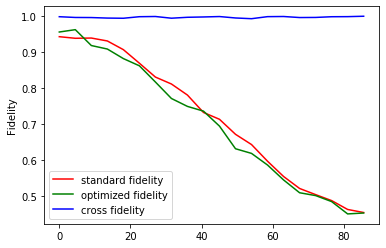

In [59]:
# raw
plt.plot(thetas * 180 / np.pi, standard_fidelities, 'r')
plt.plot(thetas * 180 / np.pi, optimized_fidelities, 'g')
plt.plot(thetas * 180 / np.pi, cross_fidelities, 'b')
plt.ylabel('Fidelity')
plt.legend(['standard fidelity', 'optimized fidelity', 'cross fidelity'])

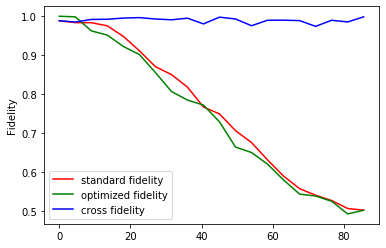

In [66]:
# mitigated
plt.plot(thetas * 180 / np.pi, standard_fidelities, 'r')
plt.plot(thetas * 180 / np.pi, optimized_fidelities, 'g')
plt.plot(thetas * 180 / np.pi, cross_fidelities, 'b')
plt.ylabel('Fidelity')
plt.legend(['standard fidelity', 'optimized fidelity', 'cross fidelity'])

### plot |11>

In [87]:
# infer output state vectors, up to phase of each element (phase won't matter for overlap calculation)
standard_00s = []
standard_11s = []
for counts in standard_counts_list:
    standard_00s.append(counts.get('00', 0))
    standard_11s.append(counts.get('11', 0))
        
optimized_00s = []
optimized_11s = []
for counts in optimized_counts_list:
    optimized_00s.append(counts.get('00', 0))
    optimized_11s.append(counts.get('11', 0))
        
ideal_00s = []
ideal_11s = []
for ideal in ideal_state_vectors:
    ideal_11s.append(1000 * np.abs(ideal[3]) ** 2)
    ideal_00s.append(1000 * np.abs(ideal[0]) ** 2)

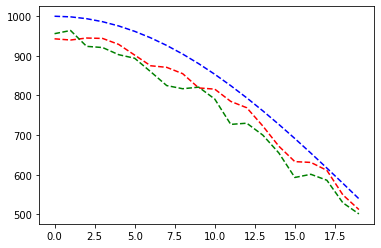

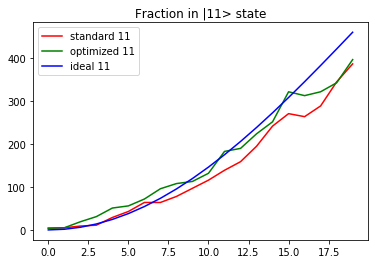

In [82]:
# raw
plt.plot(standard_00s, 'r--', label='standard 00')
plt.plot(optimized_00s, 'g--', label='optimized 00')
plt.plot(ideal_00s, 'b--', label='ideal 00')
plt.figure()
plt.plot(standard_11s, 'r', label='standard 11')
plt.plot(optimized_11s, 'g', label='optimized 11')
plt.plot(ideal_11s, 'b', label='ideal 11')
plt.title('Fraction in |11> state')
plt.legend()

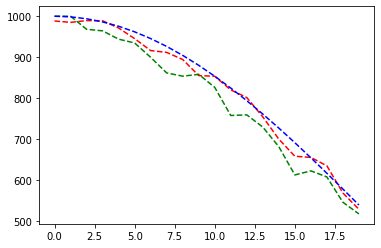

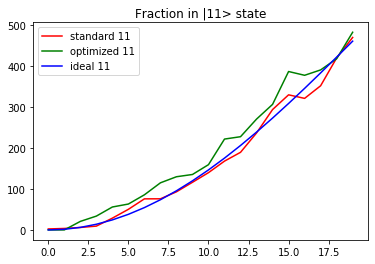

In [88]:
# mitigated
plt.plot(standard_00s, 'r--', label='standard 00')
plt.plot(optimized_00s, 'g--', label='optimized 00')
plt.plot(ideal_00s, 'b--', label='ideal 00')
plt.figure()
plt.plot(standard_11s, 'r', label='standard 11')
plt.plot(optimized_11s, 'g', label='optimized 11')
plt.plot(ideal_11s, 'b', label='ideal 11')
plt.title('Fraction in |11> state')
plt.legend()